In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Data

I created an entrapment exeperiment as follows. 

I performed an open ionbot and msfragger search (oxididation of M variable, max 2 missed cleavages).

In [2]:
#set this your local folder as the data was pushed to the repo as well
folder = "/home/compomics/tools/ionbot_paper"
dataset = "TMTCPTAC"

 # Results
 
Load ionbot PSM results (first-matches + coeluting matches + features) + protein results.

In [3]:
folder2 = folder + "/" + dataset + "_A"
ionbot_A = pd.read_csv("%s/ionbot.first.csv"%folder2)
ionbot_A["rank"] = ["first"]*len(ionbot_A)
tmp = pd.read_csv("%s/ionbot.lower.csv"%folder2)
tmp["rank"] = ["lower"]*len(tmp)
ionbot_A = pd.concat([ionbot_A,tmp])
tmp = pd.read_csv("%s/ionbot.features.csv"%folder2)
ionbot_A = ionbot_A.merge(tmp,on="ionbot_match_id",how="left")
#NO IDEA WHAT HAPPENED HERE...
ionbot_A = ionbot_A.drop_duplicates("ionbot_match_id")

In [4]:
ionbot_A = ionbot_A[(ionbot_A["database"]=="T")&(ionbot_A["q-value"]<=0.01)]

In [5]:
ionbot_A["rank"].value_counts()

first    421747
lower      7968
Name: rank, dtype: int64

In [6]:
def contains_missed_cleavage(x):
    if "K" in x[:-1]:
        return True
    if "R" in x[:-1]:
        return True
    return False

print(len(ionbot_A))
ionbot_A["contains_missed_cleavage"] = ionbot_A["matched_peptide"].apply(contains_missed_cleavage)    
#ionbot_A["num_passed"] = ionbot_A.groupby(["spectrum_title","spectrum_file"])["spectrum_title"].transform("count")
ionbot_A["num_passed"] = ionbot_A.groupby(["scan","spectrum_file"])["scan"].transform("count")
print(ionbot_A["num_passed"].value_counts())
ionbot_A = ionbot_A[(ionbot_A["num_passed"]==1) |
        (ionbot_A["rank"]=="lower") |
        ((ionbot_A["num_passed"]>1) & (ionbot_A["rank"]=="first") & (ionbot_A["unexpected_modification"].isna()) & (ionbot_A["contains_missed_cleavage"]==False))]
print(len(ionbot_A))


429715
1    413939
2     15614
3       162
Name: num_passed, dtype: int64
427013


In [7]:
#need to re-assign best_psm
print(ionbot_A["scan"])
print(ionbot_A["spectrum_title"])
#best_psms = ionbot_A.sort_values("psm_score").drop_duplicates("spectrum_title", keep="last")
best_psms = ionbot_A.sort_values("psm_score").drop_duplicates(["scan","spectrum_file"], keep="last")
print(len(best_psms))
best_psm_ids = set(best_psms["ionbot_match_id"])
print(len(best_psm_ids))
ionbot_A["rank"] = ionbot_A["ionbot_match_id"].apply(
    lambda x: "first" if x in best_psm_ids else "lower"
)


54             3
58         14238
63         14244
70         10965
75         14249
           ...  
2648898    13766
2648913    13872
2648914    13879
2648979    14155
2649056    14508
Name: scan, Length: 427013, dtype: int64
54        NaN
58        NaN
63        NaN
70        NaN
75        NaN
           ..
2648898   NaN
2648913   NaN
2648914   NaN
2648979   NaN
2649056   NaN
Name: spectrum_title, Length: 427013, dtype: float64
421800
421800


In [8]:
ionbot_A["rank"].value_counts()

first    421800
lower      5213
Name: rank, dtype: int64

In [9]:
print(ionbot_A["num_passed"].value_counts())

1    413939
2     12921
3       153
Name: num_passed, dtype: int64


In [10]:
def is_target(x):
    tmp = x.split('||')
    for t in tmp:
        #if not "SHUFFLED" in t:
        if not "ENTRAPMENT" in t:
            return True
    return False

ionbot_A["is_target"] = ionbot_A["proteins"].apply(is_target)

In [11]:
tmp1 = ionbot_A[ionbot_A["rank"]=="first"].sort_values("q-value")
tmp2 = ionbot_A[ionbot_A["rank"]=="lower"].sort_values("q-value")

In [12]:
print(len(tmp1))
print(len(tmp2))

421800
5213


In [13]:
l1 = list(tmp1["is_target"])
l2 = list(tmp1["q-value"])
X = []
c = 0
for i in range(len(l1)):
    if l2[i] > 0.01: break
    if l1[i] == False:
        c += 1
    X.append([l2[i],c/(i+1)])
d1 = pd.DataFrame(X,columns=["q-value","Entrapment FDR"])
d1["type"] = ["ionbot first"]*len(d1)
l1 = list(tmp2["is_target"])
l2 = list(tmp2["q-value"])
X = []
c = 0
for i in range(len(l1)):
    if l2[i] > 0.01: break
    if l1[i] == False:
        c += 1
    X.append([l2[i],c/(i+1)])
d2 = pd.DataFrame(X,columns=["q-value","Entrapment FDR"])
d2["type"] = ["ionbot lower"]*len(d2)
ionbot_fdr = pd.concat([d1,d2])

Let's do this for msfragger as well.

In [15]:
if dataset == "PXD001468":
    fragger = pd.read_csv("%s/msfragger/%s_A/psm.tsv"%(folder,dataset),sep="\t")
else:
    fragger = pd.read_csv("%s/msfragger/%s_A/noprotein/psm.tsv"%(folder,dataset),sep="\t")
fragger["proteins_all"] = fragger["Protein"].astype(str) + ',' + fragger["Mapped Proteins"].astype(str)

In [16]:
len(fragger)

486765

In [17]:
def is_target2(x):
    tmp = x.split(',')
    for t in tmp:
        if t == "nan":
            continue
        #if not "SHUFFLED" in t:
        if not "ENTRAPMENT" in t:
            return True
    return False

In [18]:
fragger["is_target"] = fragger["proteins_all"].apply(is_target2)
fragger["is_target"].value_counts()
efdr = len(fragger[fragger["is_target"]==False]) / len(fragger[fragger["is_target"]==True]) 
print(efdr)
fragger_full_fdr = pd.DataFrame([[0.01,efdr,"MSFragger Prophet"]],columns=["q-value","Entrapment FDR","type"])

0.0002609742765669759


In [19]:
c = 0
e = 0
X = []
with open("%s/msfragger/%s_A/o"%(folder,dataset)) as f:
    f.readline()
    for row in f:
        l = row.rstrip().split('\t')
        if float(l[2]) > 0.01: break
        c += 1
        ok = False
        for t in l[5:]:
            if not "ENTRAPMENT" in t:
                ok = True
        if ok == False:
            e += 1
        X.append([float(l[2]),e / c])
fragger_fdr = pd.DataFrame(X,columns=["q-value","Entrapment FDR"])

In [20]:
fragger_fdr["type"] = ["MSFragger Percolator"]*len(fragger_fdr)
tmp = pd.concat([ionbot_fdr,fragger_fdr,fragger_full_fdr])
tmp["type"].value_counts()

MSFragger Percolator    474819
ionbot first            421800
ionbot lower              5213
MSFragger Prophet            1
Name: type, dtype: int64

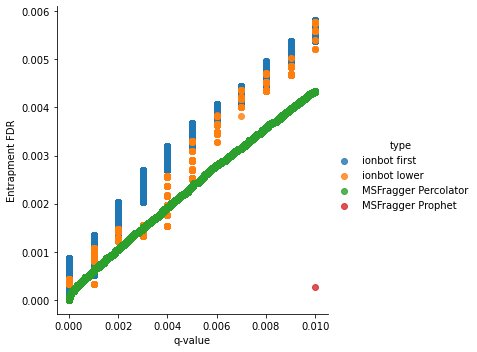

In [21]:
sns.lmplot(x="q-value",y="Entrapment FDR",hue="type",data=tmp,fit_reg=False)